<a href="https://colab.research.google.com/github/savi664/MachineLearningProject/blob/main/2425575.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CM2604 Project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## End-to-End Customer churn prediction project

### Data

Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

### Importing all the required modules and packages

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC,SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay,roc_auc_score
from sklearn.model_selection import cross_val_score

### EDA (Exploratory Data Analysis)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CM2604/Project/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
#Getting the info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [ ]:
#Checking for duplicates
df.duplicated().sum()

np.int64(0)

<Axes: xlabel='Churn'>

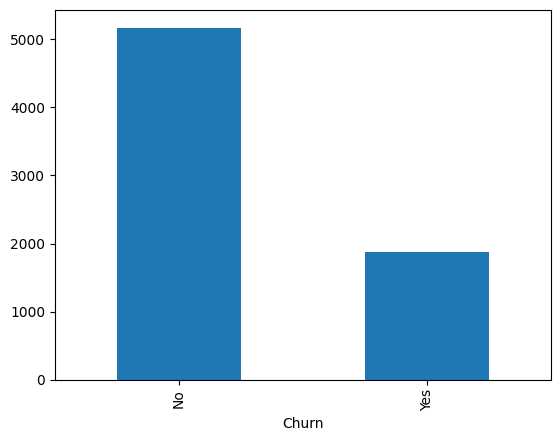

In [ ]:
#Checking for class imbalances
df.Churn.value_counts().plot.bar()

In [ ]:
#Checking if there are null values and converting the total charges into a numeric
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


## Preprocessing for Model training

In [ ]:
# Drop customerID and clean TotalCharges
df.drop("customerID", axis=1, inplace=True)

#Total charges can  be calculated by number of months the user has been a customer(tenure) multiplied by the Monthly charges
df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)

# Split X and y
X = df.drop("Churn", axis=1)
y = df["Churn"].map({'No': 0, 'Yes': 1})

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define column groups FROM x_train ONLY
cat_col = [col for col in x_train.select_dtypes(include='object') if x_train[col].nunique() >= 2]
num_col = ["tenure", "MonthlyCharges", "TotalCharges"]

# Build transformer
transformer = ColumnTransformer([
    ('one_hot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_col),
    ('scaler', StandardScaler(), num_col)
], remainder='drop')

# Fit on train, transform both
X_train_processed = transformer.fit_transform(x_train)
X_test_processed = transformer.transform(x_test)

#Get Categorical data names out
cat_col_names = transformer.named_transformers_['one_hot'].get_feature_names_out(cat_col)
cat_indices = list(range(len(cat_col_names)))

smotenc = SMOTENC(
    categorical_features = cat_indices,
    sampling_strategy='auto',
    random_state=42,
    k_neighbors=5
)

# Fit and transform the data
X_resampled, y_resampled = smotenc.fit_resample(X_train_processed, y_train)


/tmp/ipython-input-4118871065.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)


In [ ]:
X_train_processed

array([[ 1.        ,  0.        ,  0.        , ...,  0.10237124,
        -0.52197565, -0.2622572 ],
       [ 1.        ,  1.        ,  1.        , ..., -0.71174346,
         0.33747781, -0.50363479],
       [ 1.        ,  1.        ,  1.        , ..., -0.79315493,
        -0.80901319, -0.74988292],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.30468611,
         1.25666162,  0.15834357],
       [ 0.        ,  1.        ,  0.        , ..., -0.34539184,
        -1.47766135, -0.79707463],
       [ 1.        ,  0.        ,  0.        , ..., -1.07809507,
        -1.46936546, -0.96096216]])

## Model training(Base Model)

### Decision tree Model

In [42]:
treeClassifier = DecisionTreeClassifier(random_state=42)
treeClassifier.fit(X_train_processed, y_train)
treeClassifier.score(X_test_processed,y_test)

0.7409510290986515

### NN(Neural Network Model) Model

In [ ]:
## Calculating the class weight and applying it in training to deal with class imbalances
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print("Class weights:", class_weights)

Class weights: {np.int64(0): np.float64(0.6805991785455424), np.int64(1): np.float64(1.8842809364548494)}


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_processed.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),


    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
#Createating callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(0.001),metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])

In [ ]:
# NN model is trained on normal processed data instead of sampled data to avoid noise from smote
np.random.seed(42)
model.fit(X_train_processed,y_train, epochs = 100,class_weight=class_weights, validation_data=(X_test_processed,y_test), callbacks=[early_stopping,lr_scheduler],batch_size = 32)

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6525 - auc: 0.7413 - loss: 0.6443 - val_accuracy: 0.7275 - val_auc: 0.8214 - val_loss: 0.5232 - learning_rate: 0.0010
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7287 - auc: 0.8263 - loss: 0.5204 - val_accuracy: 0.7275 - val_auc: 0.8287 - val_loss: 0.4951 - learning_rate: 0.0010
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7421 - auc: 0.8378 - loss: 0.5078 - val_accuracy: 0.7253 - val_auc: 0.8344 - val_loss: 0.5089 - learning_rate: 0.0010
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7483 - auc: 0.8482 - loss: 0.4889 - val_accuracy: 0.7282 - val_auc: 0.8363 - val_loss: 0.4911 - learning_rate: 0.0010
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7538 - auc: 0.8463 - loss: 0.4809 - val_accuracy: 0.7353 - val_auc: 0.8368 - val_loss: 0.5001 - learning_rate: 5.0000e-04
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7469

In [ ]:
model.evaluate(X_test_processed,y_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7296 - auc: 0.8307 - loss: 0.5091


[0.502610981464386, 0.7324343323707581, 0.837482213973999]

##Hyper parameter tuning

### Hyper parameter tuning the Decision tree model

In [ ]:
treeClassifier.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
#Best hyper parameter tuning grid for a descion tree model
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': [None, 5, 8, 10, 12, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', None],
    'class_weight': ['balanced'],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01]
}

In [ ]:
grid = GridSearchCV(treeClassifier, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose = 2)
grid.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.001, 0.005, 0.01],
                         'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 8, 10, 12, 15],
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best']},
             scoring='roc_auc', verbose=2)

In [ ]:
grid.best_params_

{'ccp_alpha': 0.001,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'splitter': 'best'}

In [ ]:
#Creating a instance of the tree class that had the best outcome
best_Treeclassifier = grid.best_estimator_
best_Treeclassifier.fit(X_train_processed, y_train)
best_Treeclassifier.score(X_test_processed,y_test)

0.7352732434350603

### Hyper parameter tuning NN model(Creating one + Finding the best params)

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
def build_nn_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train_processed.shape[1],)))

    activation = hp.Choice('activation', ['relu', 'tanh'])

    for i in range(hp.Int('num_layers', 2, 4)):
        units = hp.Int(f'layer_{i}', min_value=32, max_value=512, step=64)
        model.add(tf.keras.layers.Dense(units, activation=activation,
                               kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2', 1e-5, 1e-2, sampling='log'))))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [ ]:
import keras_tuner as kt

tuner = kt.Hyperband(build_nn_model,
                     objective='val_auc',
                     max_epochs=50,
                     factor=3,
                     )

In [ ]:
tuner.search(X_train_processed, y_train, epochs=10, validation_data=(X_test_processed, y_test),class_weight=class_weights, callbacks=[early_stopping,lr_scheduler])

Trial 90 Complete [00h 00m 30s]
val_auc: 0.8413340449333191

Best val_auc So Far: 0.8446807861328125
Total elapsed time: 00h 23m 47s


In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_nn_model = tuner.hypermodel.build(best_hp)
best_nn_model.fit(X_train_processed, y_train, epochs=100, validation_data=(X_test_processed, y_test),class_weight=class_weights, callbacks=[early_stopping,lr_scheduler])

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.6641 - auc: 0.7445 - loss: 0.8771 - val_accuracy: 0.6352 - val_auc: 0.7493 - val_loss: 0.7506 - learning_rate: 0.0100
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7204 - auc: 0.7833 - loss: 0.7249 - val_accuracy: 0.6650 - val_auc: 0.8179 - val_loss: 0.6852 - learning_rate: 0.0100
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7110 - auc: 0.8094 - loss: 0.6557 - val_accuracy: 0.7587 - val_auc: 0.8402 - val_loss: 0.5767 - learning_rate: 0.0100
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7391 - auc: 0.8039 - loss: 0.6539 - val_accuracy: 0.7289 - val_auc: 0.8422 - val_loss: 0.6164 - learning_rate: 0.0100
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7552 - auc: 0.8325 - loss: 0.5883 - val_accuracy: 0.7828 - val_auc: 0.8432 - val_loss: 0.5314 - learning_rate: 0.0050
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7

In [ ]:
best_nn_model.evaluate(X_test_processed,y_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7780 - auc: 0.8385 - loss: 0.5389


[0.5314246416091919, 0.782824695110321, 0.8431618213653564]

## Model Evaluation

## Evaluating the tree classifier

In [ ]:
tree_prediction = treeClassifier.predict(X_test_processed)

In [ ]:
pd.DataFrame(classification_report(y_test,tree_prediction,output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.830508,0.460215,0.708304,0.645362,0.732219
recall,0.757488,0.572193,0.708304,0.664840,0.708304
f1-score,0.792319,0.510131,0.708304,0.651225,0.717416
support,1035.000000,374.000000,0.708304,1409.000000,1409.000000


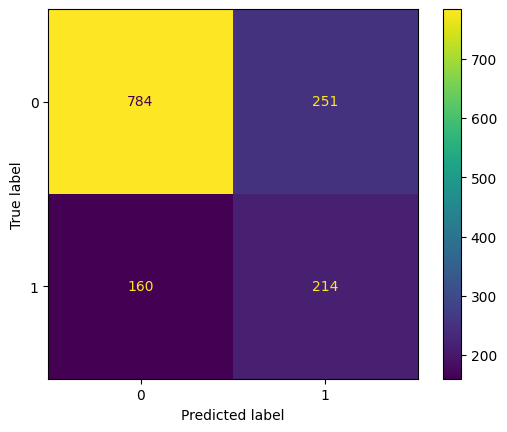

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,tree_prediction)

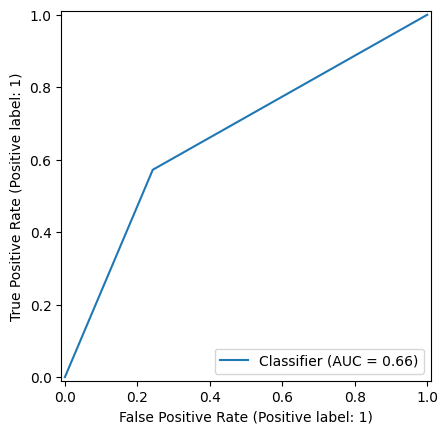

In [ ]:
RocCurveDisplay.from_predictions(y_test,tree_prediction)

In [ ]:
roc_auc_score(y_test,tree_prediction)

np.float64(0.6648402180371489)

### Using Cross validation to validate the tree model

In [ ]:
# Precision score
np.mean(cross_val_score(treeClassifier,X_test_processed,y_test,cv=5,scoring='precision'))

np.float64(0.47914400161945697)

In [ ]:
#Recall score
np.mean(cross_val_score(treeClassifier,X_test_processed,y_test,cv=5,scoring='recall'))

np.float64(0.5267027027027027)

In [ ]:
#F1 score
np.mean(cross_val_score(treeClassifier,X_test_processed,y_test,cv=5,scoring='f1'))

np.float64(0.5012567107061311)

In [ ]:
#accuracy
np.mean(cross_val_score(treeClassifier,X_test_processed,y_test,cv=5,scoring='accuracy'))

np.float64(0.7224931223341157)

### Evaluating the NN

In [44]:
NN_predictions = best_nn_model.predict(X_test_processed)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


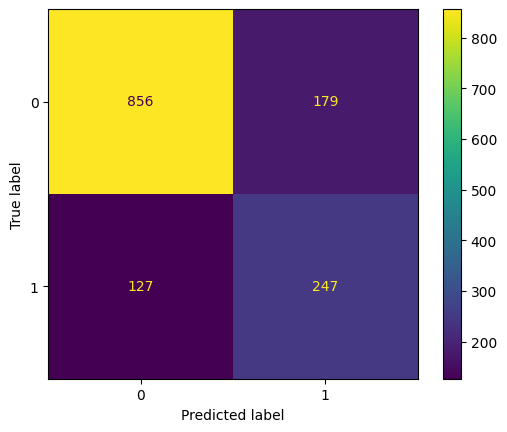

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test,NN_predictions.round())

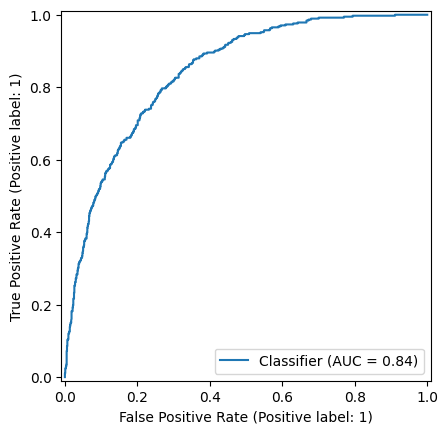

In [50]:
#Roc curve
RocCurveDisplay.from_predictions(y_test,NN_predictions)